# Pretrained model weights are not frozen it changes during training
 unless  explicitly set them to requires_grad=False
 
 #Freeze the pretrained layers
        for param in self.convnet.parameters():
            param.requires_grad = False

# First Approach: Direct Replacement
Load the pretrained ResNet-18 model
self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')

Replace the first convolutional layer with a new one that takes 1 input channel
self.convnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

What it does: This approach directly replaces the original conv1 layer, which expects 3 input channels, with a new conv1 layer that expects 1 input channel.
Consequence: The new convolutional layer is initialized with random weights (using PyTorch's default initialization strategy). It does not retain any information from the original model's weights, meaning the benefits of pre-training for this layer are lost.

In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import random

In [2]:
# Set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed
set_seed(42)

In [3]:
# Custom Dataset class
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.tiff')]
        self.resize_transform = transforms.Resize((96,96))
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")
        
        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0
        
        # Calculate sharpness for each layer
        sharpness_scores = []
        for i in range(3):
            layer = image[i]
            gy, gx = np.gradient(layer)
            gnorm = np.sqrt(gx**2 + gy**2)
            sharpness = np.average(gnorm)
            sharpness_scores.append(sharpness)
        

        # Find the index of the sharpest layer
        sharpest_layer_index = np.argmax(sharpness_scores)
        
        # Determine the anchor (sharpest layer) and the other two layers (augmentations)
        anchor = image[sharpest_layer_index]
        other_indices = [i for i in range(3) if i != sharpest_layer_index]
        augmentation1 = image[other_indices[0]]
        augmentation2 = image[other_indices[1]]

        # Convert to a torch tensor and add channel dimension
        anchor = torch.tensor(anchor, dtype=torch.float32).unsqueeze(0)
        img1 = torch.tensor(augmentation1, dtype=torch.float32).unsqueeze(0)
        img2 = torch.tensor(augmentation2, dtype=torch.float32).unsqueeze(0)
        
        # Apply resize transform
        anchor = self.resize_transform(anchor)
        img1 = self.resize_transform(img1)
        img2 = self.resize_transform(img2)


        # Apply resize transform
        anchor = self.resize_transform(anchor)
        img1 = self.resize_transform(img1)
        img2 = self.resize_transform(img2)
        
        return img1, img2

# Create the dataset
image_dir = r"../../tiff_experiment_unsupervised_data/combined"
dataset = ImageDataset(image_dir=image_dir)
batch_size = 16

# Function to split dataset with explicit percentage
def split_dataset(dataset, val_percentage):
    val_size = int(len(dataset) * val_percentage)
    train_size = len(dataset) - val_size
    return random_split(dataset, [train_size, val_size])

# Split the dataset with 20% for validation
val_percentage = 0.2
train_dataset, val_dataset = split_dataset(dataset, val_percentage)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0)

In [4]:
for i, (img1, img2) in enumerate(train_loader):
    print(f"Batch {i}:")
    print(f"  Image1: {img1.shape}")
    print(f"  Image2: {img2.shape}")
    break

Batch 0:
  Image1: torch.Size([16, 1, 96, 96])
  Image2: torch.Size([16, 1, 96, 96])


In [5]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


In [6]:
def plot_curves(train_losses, val_losses, train_top1_accs, val_top1_accs, train_top5_accs, val_top5_accs):
    epochs = range(1, len(train_losses) + 1)
    
    # Plot loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Top-1 accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_top1_accs, 'bo-', label='Training Top-1 Accuracy')
    plt.plot(epochs, val_top1_accs, 'ro-', label='Validation Top-1 Accuracy')
    plt.title('Training and Validation Top-1 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Top-1 Accuracy (%)')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()
    
    # Plot Top-5 accuracy
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, train_top5_accs, 'bo-', label='Training Top-5 Accuracy')
    plt.plot(epochs, val_top5_accs, 'ro-', label='Validation Top-5 Accuracy')
    plt.title('Training and Validation Top-5 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Top-5 Accuracy (%)')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()


In [7]:
# Define the SimCLR model class (plain PyTorch version)
class SimCLR(nn.Module):
    def __init__(self, hidden_dim, lr, temperature, weight_decay):
        super().__init__()
        self.temperature = temperature
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        self.convnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, hidden_dim)  # Output layer with hidden_dim output
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=50, eta_min=lr / 50)

    def forward(self, x):
        return self.convnet(x)

    def info_nce_loss(self, img1, img2, device):
        imgs = torch.cat((img1, img2), dim=0)  # Concatenate along the batch dimension
        imgs = imgs.to(device)  # Move images to the device

        # Encode all images
        feats = self.forward(imgs)
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)

        # if concanated image have dfifferent format use below one
        # Create target tensor
        '''target = torch.arange(cos_sim.shape[0], device=cos_sim.device)
        target[0::2] += 1
        target[1::2] -= 1
        index = target.reshape(cos_sim.shape[0], 1).long()

        # Prepare ground_truth_labels
        ground_truth_labels = torch.zeros(cos_sim.shape[0], cos_sim.shape[0], device=cos_sim.device).long()
        src = torch.ones(cos_sim.shape[0], cos_sim.shape[0], device=cos_sim.device).long()
        ground_truth_labels = torch.scatter(ground_truth_labels, 1, index, src)
        pos_mask = ground_truth_labels.bool()'''
        # InfoNCE loss
        cos_sim = cos_sim / self.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        return nll

    def train_epoch(self, train_loader, device):
        self.train()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        for batch in tqdm(train_loader, desc="Training", leave=False):
            imgs1, imgs2 = batch
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
            self.optimizer.zero_grad()
            loss = self.info_nce_loss(imgs1, imgs2, device)
            loss.backward()
            self.optimizer.step()
            self.lr_scheduler.step()
            total_loss += loss.item()

            # Compute accuracies
            feats = self.forward(torch.cat((imgs1, imgs2), dim=0))
            target = torch.cat((torch.arange(imgs1.size(0)), torch.arange(imgs2.size(0)))).to(device)
            top1_acc, top5_acc = accuracy(feats, target, topk=(1, 5))
            total_top1_acc += top1_acc.item()
            total_top5_acc += top5_acc.item()

        avg_loss = total_loss / len(train_loader)
        avg_top1_acc = total_top1_acc / len(train_loader)
        avg_top5_acc = total_top5_acc / len(train_loader)
        return avg_loss, avg_top1_acc, avg_top5_acc

    def validate_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating", leave=False):
                imgs1, imgs2 = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
                loss = self.info_nce_loss(imgs1, imgs2, device)
                total_loss += loss.item()

                # Compute accuracies
                feats = self.forward(torch.cat((imgs1, imgs2), dim=0))
                target = torch.cat((torch.arange(imgs1.size(0)), torch.arange(imgs2.size(0)))).to(device)
                top1_acc, top5_acc = accuracy(feats, target, topk=(1, 5))
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()

        avg_loss = total_loss / len(val_loader)
        avg_top1_acc = total_top1_acc / len(val_loader)
        avg_top5_acc = total_top5_acc / len(val_loader)
        return avg_loss, avg_top1_acc, avg_top5_acc



In [8]:
def train_simclr(batch_size, max_epochs=50, hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4):
    # Determine the device to use
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize the model and move it to the device
    model = SimCLR(hidden_dim=hidden_dim, lr=lr, temperature=temperature, weight_decay=weight_decay).to(device)
    
    # Lists to store the loss and accuracy values
    train_losses, val_losses = [], []
    train_top1_accs, val_top1_accs = [], []
    train_top5_accs, val_top5_accs = [], []

    # Start time for the entire training
    start_time = time.time()

    for epoch in range(max_epochs):
        # Start time for the epoch
        epoch_start_time = time.time()

        # Train the model for one epoch and get the metrics
        train_loss, train_top1_acc, train_top5_acc = model.train_epoch(train_loader, device)
        val_loss, val_top1_acc, val_top5_acc = model.validate_epoch(val_loader, device)
        
        # Store the metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_top1_accs.append(train_top1_acc)
        val_top1_accs.append(val_top1_acc)
        train_top5_accs.append(train_top5_acc)
        val_top5_accs.append(val_top5_acc)
        
        # Calculate the elapsed time for the epoch
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time

        # Print the metrics and the time taken for the epoch 
        print(f"Epoch {epoch+1}/{max_epochs} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Top-1 Acc: {train_top1_acc:.2f}% | "
              f"Top-5 Acc: {train_top5_acc:.2f}% | "
              f"Validation Loss: {val_loss:.4f} | "
              f"Top-1 Acc: {val_top1_acc:.2f}% | "
              f"Top-5 Acc: {val_top5_acc:.2f}% | "
              f"Time Taken: {epoch_duration:.2f} seconds")

    # Total time for training
    end_time = time.time()
    total_duration = end_time - start_time
    print(f"Total Training Time: {total_duration:.2f} seconds")

    # After training, plot the curves
    plot_curves(train_losses, val_losses, train_top1_accs, val_top1_accs, train_top5_accs, val_top5_accs)

Using device: cuda


Epoch 1/2 | Train Loss: 0.0141 | Top-1 Acc: 0.33% | Top-5 Acc: 1.97% | Validation Loss: 0.1396 | Top-1 Acc: 0.00% | Top-5 Acc: 1.25% | Time Taken: 83.60 seconds


Epoch 2/2 | Train Loss: 0.0043 | Top-1 Acc: 0.49% | Top-5 Acc: 5.00% | Validation Loss: 0.0042 | Top-1 Acc: 0.00% | Top-5 Acc: 1.25% | Time Taken: 83.23 seconds
Total Training Time: 166.83 seconds


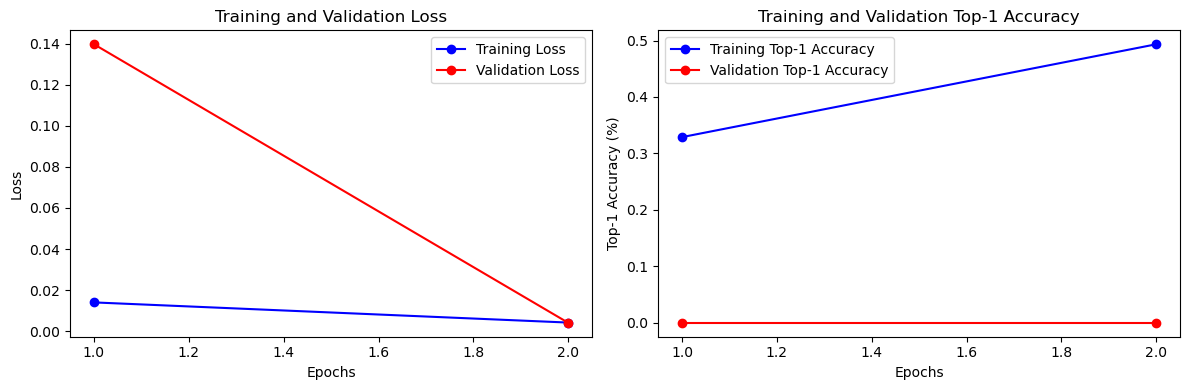

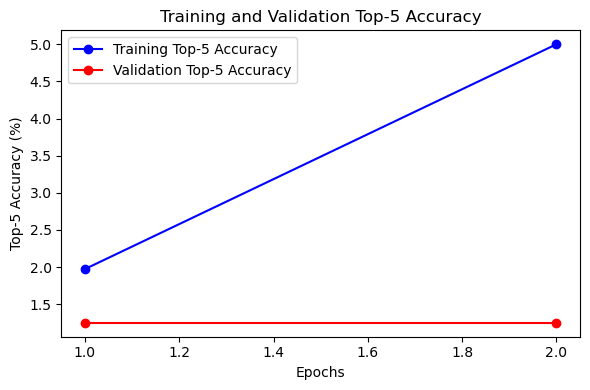

In [9]:
# Run the training script
train_simclr(batch_size=16, hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4, max_epochs=2)

# Second Approach: Weight Conversion

What it does: This approach also replaces the original conv1 layer with a new one that takes 1 input channel. However, it first clones the original weights of conv1, sums them across the input channel dimension, and assigns the result to the new layer.
Consequence: The new conv1 layer is initialized in such a way that it retains information from the original pre-trained weights. Summing the weights across the input channels effectively combines the learned features from the RGB channels into a single channel, preserving the pre-trained knowledge as much as possible.

#Load the pretrained ResNet-18 model

self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')

#Clone the original weights of conv1

weight = self.convnet.conv1.weight.clone()

#Replace the first convolutional layer with a new one that takes 1 input channel

self.convnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

#Sum the original weights across the channel dimension and assign them to the new conv1 layer

self.convnet.conv1.weight.data = weight.sum(dim=1, keepdim=True)


In [10]:
# Define the SimCLR model class (plain PyTorch version)
class SimCLR_weight_converted(nn.Module):
    def __init__(self, hidden_dim, lr, temperature, weight_decay):
        super().__init__()
        self.temperature = temperature
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        weight = self.convnet.conv1.weight.clone()
        self.convnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.convnet.conv1.weight.data = weight.sum(dim=1, keepdim=True)
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, hidden_dim)  # Output layer with hidden_dim output
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=50, eta_min=lr / 50)

    def forward(self, x):
        return self.convnet(x)

    def info_nce_loss(self, img1, img2, device):
        imgs = torch.cat((img1, img2), dim=0)  # Concatenate along the batch dimension
        imgs = imgs.to(device)  # Move images to the device

        # Encode all images
        feats = self.forward(imgs)
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)

        '''#if concanated image have dfifferent format use below one
        # Create target tensor
        target = torch.arange(cos_sim.shape[0], device=cos_sim.device)
        target[0::2] += 1
        target[1::2] -= 1
        index = target.reshape(cos_sim.shape[0], 1).long()

        # Prepare ground_truth_labels
        ground_truth_labels = torch.zeros(cos_sim.shape[0], cos_sim.shape[0], device=cos_sim.device).long()
        src = torch.ones(cos_sim.shape[0], cos_sim.shape[0], device=cos_sim.device).long()
        ground_truth_labels = torch.scatter(ground_truth_labels, 1, index, src)
        pos_mask = ground_truth_labels.bool()'''
        # InfoNCE loss
        cos_sim = cos_sim / self.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        return nll

    def train_epoch(self, train_loader, device):
        self.train()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        for batch in tqdm(train_loader, desc="Training", leave=False):
            imgs1, imgs2 = batch
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
            self.optimizer.zero_grad()
            loss = self.info_nce_loss(imgs1, imgs2, device)
            loss.backward()
            self.optimizer.step()
            self.lr_scheduler.step()
            total_loss += loss.item()

            # Compute accuracies
            feats = self.forward(torch.cat((imgs1, imgs2), dim=0))
            target = torch.cat((torch.arange(imgs1.size(0)), torch.arange(imgs2.size(0)))).to(device)
            top1_acc, top5_acc = accuracy(feats, target, topk=(1, 5))
            total_top1_acc += top1_acc.item()
            total_top5_acc += top5_acc.item()

        avg_loss = total_loss / len(train_loader)
        avg_top1_acc = total_top1_acc / len(train_loader)
        avg_top5_acc = total_top5_acc / len(train_loader)
        return avg_loss, avg_top1_acc, avg_top5_acc

    def validate_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating", leave=False):
                imgs1, imgs2 = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
                loss = self.info_nce_loss(imgs1, imgs2, device)
                total_loss += loss.item()

                # Compute accuracies
                feats = self.forward(torch.cat((imgs1, imgs2), dim=0))
                target = torch.cat((torch.arange(imgs1.size(0)), torch.arange(imgs2.size(0)))).to(device)
                top1_acc, top5_acc = accuracy(feats, target, topk=(1, 5))
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()

        avg_loss = total_loss / len(val_loader)
        avg_top1_acc = total_top1_acc / len(val_loader)
        avg_top5_acc = total_top5_acc / len(val_loader)
        return avg_loss, avg_top1_acc, avg_top5_acc


In [11]:
def train_simclr(batch_size, max_epochs=50, hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4):
    # Determine the device to use
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize the model and move it to the device
    model = SimCLR_weight_converted(hidden_dim=hidden_dim, lr=lr, temperature=temperature, weight_decay=weight_decay).to(device)
    
    # Lists to store the loss and accuracy values
    train_losses, val_losses = [], []
    train_top1_accs, val_top1_accs = [], []
    train_top5_accs, val_top5_accs = [], []

    # Start time for the entire training
    start_time = time.time()

    for epoch in range(max_epochs):
        # Start time for the epoch
        epoch_start_time = time.time()

        # Train the model for one epoch and get the metrics
        train_loss, train_top1_acc, train_top5_acc = model.train_epoch(train_loader, device)
        val_loss, val_top1_acc, val_top5_acc = model.validate_epoch(val_loader, device)
        
        # Store the metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_top1_accs.append(train_top1_acc)
        val_top1_accs.append(val_top1_acc)
        train_top5_accs.append(train_top5_acc)
        val_top5_accs.append(val_top5_acc)
        
        # Calculate the elapsed time for the epoch
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time

        # Print the metrics and the time taken for the epoch 
        print(f"Epoch {epoch+1}/{max_epochs} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Top-1 Acc: {train_top1_acc:.2f}% | "
              f"Top-5 Acc: {train_top5_acc:.2f}% | "
              f"Validation Loss: {val_loss:.4f} | "
              f"Top-1 Acc: {val_top1_acc:.2f}% | "
              f"Top-5 Acc: {val_top5_acc:.2f}% | "
              f"Time Taken: {epoch_duration:.2f} seconds")


    # Total time for training
    end_time = time.time()
    total_duration = end_time - start_time
    print(f"Total Training Time: {total_duration:.2f} seconds")

    # After training, plot the curves
    plot_curves(train_losses, val_losses, train_top1_accs, val_top1_accs, train_top5_accs, val_top5_accs)

Using device: cuda


Epoch 1/2 | Train Loss: 0.0166 | Top-1 Acc: 0.00% | Top-5 Acc: 3.12% | Validation Loss: 0.0754 | Top-1 Acc: 0.00% | Top-5 Acc: 1.25% | Time Taken: 85.53 seconds


Epoch 2/2 | Train Loss: 0.0033 | Top-1 Acc: 0.66% | Top-5 Acc: 3.12% | Validation Loss: 0.0073 | Top-1 Acc: 0.00% | Top-5 Acc: 2.50% | Time Taken: 81.58 seconds
Total Training Time: 167.11 seconds


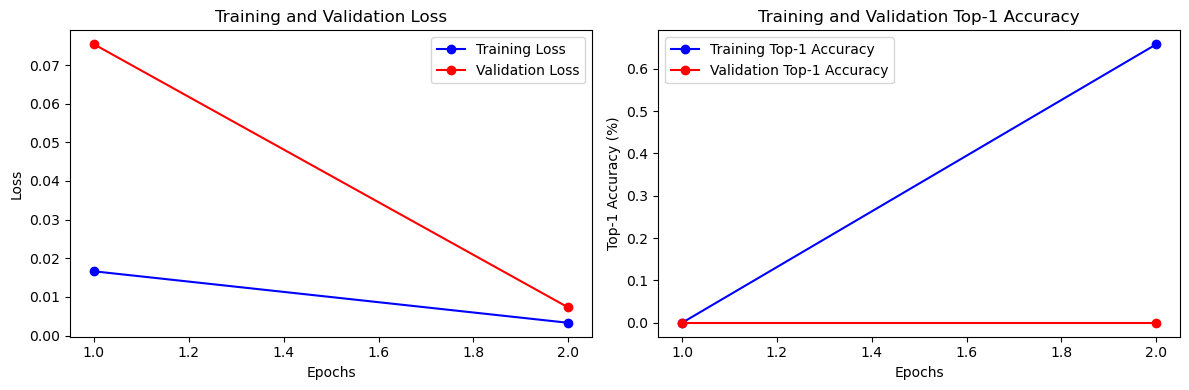

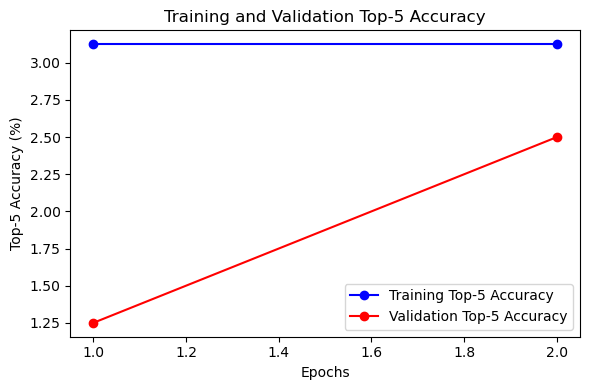

In [12]:
# Run the training script
train_simclr(batch_size=16, hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4, max_epochs=2)